# Retinex-Net 用於低光度影像增強(low-light image enhancement)

**參考:** [weichen582](https://github.com/weichen582/RetinexNet)<br>
**說明與修改:** [黃皓偉](https://github.com/HuangHW012/110_02_Structural-Machine-Learning-Models-and-Their-Applications)<br>
**修改時間:** 2022/06/12<br>

**Description:** 實作Retinex-Net

## 簡要說明

# **Retinex-Net** <br>
1. 類型: Supervised Learning <br>
2. 特色: 使用Retinex Theory理論，達到低光度影像之增強 (傳統理論搭配機器學習)機器學習) <br>
3. Retinex Theory理論: $S(x) = R(x) * I(x)$ <br>
5. 請注意，本論文需要有正常(高光度)影像作為訓練參考! 

### References

- [Deep Retinex Decomposition for Low-Light Enhancement](https://arxiv.org/abs/1808.04560)
- [A Tensorflow implementation of RetinexNet (TF 1.X)](https://github.com/weichen582/RetinexNet)

## 下載 LOLDataset

# **LoL Dataset** (paired data)<br>
1. Training set (our485): low light + high light <br>
2. Test set (eval15): low light + high light <br>

※ 請注意，訓練Retinex-Net模型需要paired fata

In [ ]:
# 從Google雲端下載資料集
!gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
!unzip -q lol_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
To: /content/lol_dataset.zip
100% 347M/347M [00:01<00:00, 245MB/s]


In [ ]:
# 匯入必要函式庫
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 實驗設定
1. Resize image to 256 X 256 (RGB channel) <br>
2. Preprocessing : [0, 255] -> [0, 1] <br>
3. Batch size: 8 <br>
4. Epochs : 100 <br>
5. Optimizer : Adam (learning rate = 0.0002) <br>

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 8
MAX_TRAIN_IMAGES = 350

# 預處理資料集，主要將影像範圍限縮至[0. 1]，作者使用其他方法限縮範圍，我僅全體/255.0
def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    #image = (image / 127.5) - 1.0
    return image
# 為了後續方便訓練，先將事先準備好的資料集依照設定Batch切割，可以查看shape
def data_generator(light_images):
    dataset = tf.data.Dataset.from_tensor_slices((light_images))
    # 套用load_data()函式
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    # 依照Batch切割原始資料集
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

# 將資料集劃分low與high光照[訓練]集
train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_high_light_images = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]
# 將資料集劃分low與high光照[驗證]集
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_high_light_images = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]
# 將資料集劃分low與high光照[測試]集
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))
test_high_light_images = sorted(glob("./lol_dataset/eval15/high/*"))


# 產生Tensorflow之資料集格式
train_low_light_dataset = data_generator(train_low_light_images)
train_high_light_dataset = data_generator(train_high_light_images)

val_low_light_dataset = data_generator(val_low_light_images)
val_high_light_dataset = data_generator(val_high_light_images)

test_low_light_dataset = data_generator(test_low_light_images)
test_high_light_dataset = data_generator(test_high_light_images)


print("Train Dataset (low light):", train_low_light_dataset)
print("Train Dataset (high light):", train_high_light_dataset)

Train Dataset (low light): <BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Train Dataset (high light): <BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


## Retinex-Net 架構

![](https://pic2.zhimg.com/80/v2-0e94f8cc619bbb6a8a679d9d79b6a671_720w.jpg)


In [ ]:
def concat(layers):
    return tf.concat(layers, axis=3)

In [ ]:
def DecomNet(layer_num = 5, channel = 64, kernel_size = 3):
    input_im = keras.Input(shape=[None, None, 2], name = "input_im")

    input_max = tf.reduce_max(input_im, axis=3, keepdims=True)
    input_im = concat([input_max, input_im])
    conv = tf.keras.layers.Conv2D(channel, kernel_size * 3, padding='same', activation=None, name="shallow_feature_extraction")(input_im)
    for idx in range(layer_num):
        conv = tf.keras.layers.Conv2D(channel, kernel_size, padding='same', activation="relu", name='activated_layer_%d' % idx)(conv)
    conv = tf.keras.layers.Conv2D(4, kernel_size, padding='same', activation=None, name='recon_layer')(conv)

    R = tf.sigmoid(conv[:,:,:,0:3])
    L = tf.sigmoid(conv[:,:,:,3:4])

    return keras.models.Model(inputs=input_im, outputs=[R, L], name='DecomNet') 

In [ ]:
def RelightNet(channel=64, kernel_size=3):
    input_L = keras.Input(shape=[None, None, 1], name = "input_L")
    input_R = keras.Input(shape=[None, None, 3], name = "input_R")

    input_im = concat([input_R, input_L])
    
    conv0 = tf.keras.layers.Conv2D(channel, (kernel_size, kernel_size), padding='same', activation=None)(input_im)
    conv1 = tf.keras.layers.Conv2D(channel, (kernel_size, kernel_size), strides=2, padding='same', activation="relu")(conv0)
    conv2 = tf.keras.layers.Conv2D(channel, (kernel_size, kernel_size), strides=2, padding='same', activation="relu")(conv1)
    conv3 = tf.keras.layers.Conv2D(channel, (kernel_size, kernel_size), strides=2, padding='same', activation="relu")(conv2)
        
    up1 = tf.image.resize(conv3, [tf.shape(conv2)[1], tf.shape(conv2)[2]], method = 'nearest')
    deconv1 = tf.keras.layers.Conv2D(channel, (kernel_size, kernel_size), padding='same', activation="relu")(up1) + conv2
    #https://www.tensorflow.org/api_docs/python/tf/image/resize
    up2 = tf.image.resize(deconv1, [tf.shape(conv1)[1], tf.shape(conv1)[2]], method = 'nearest')
    deconv2= tf.keras.layers.Conv2D(channel, (kernel_size, kernel_size), padding='same', activation="relu")(up2) + conv1
    up3 = tf.image.resize(deconv2,[tf.shape(conv0)[1], tf.shape(conv0)[2]], method = 'nearest')
    deconv3 = tf.keras.layers.Conv2D(channel, (kernel_size, kernel_size), padding='same', activation="relu")(up3) + conv0
        
    deconv1_resize = tf.image.resize(deconv1, [tf.shape(deconv3)[1], tf.shape(deconv3)[2]], method = 'nearest')
    deconv2_resize = tf.image.resize(deconv2, [tf.shape(deconv3)[1], tf.shape(deconv3)[2]], method = 'nearest')
    feature_gather = concat([deconv1_resize, deconv2_resize, deconv3])
    feature_fusion = tf.keras.layers.Conv2D(channel, 1, padding='same', activation=None)(feature_gather)
    output = tf.keras.layers.Conv2D(1, 3, padding='same', activation=None)(feature_fusion)

    return keras.models.Model(inputs=[input_L, input_R], outputs=output, name='RelightNet')  

In [ ]:
def build_RetinexNet():
    DecomNet_layer_num = 5
    input_img_low = keras.Input(shape=[None, None, 3])
    input_img_high = keras.Input(shape=[None, None, 3])

    [R_low, I_low] = DecomNet(input_img_low, layer_num=DecomNet_layer_num)
    [R_high, I_high] = DecomNet(input_img_high, layer_num=DecomNet_layer_num)


    I_delta = RelightNet(I_low, R_low)

    I_low_3 = concat([I_low, I_low, I_low])
    I_high_3 = concat([I_high, I_high, I_high])
    I_delta_3 = concat([I_delta, I_delta, I_delta])

    S = R_low * I_delta_3

    return keras.Model(inputs=[input_img_low, input_img_high], outputs=[R_low, I_low, R_high, I_high, I_delta, I_low_3, I_high_3, I_delta_3, S])

## Loss functions

##主要分成3種loss##
1. Reconstruction Loss ($ℒ_{recon}$) <br>
2. Illumination Smoothness Loss ($ℒ_{is}$) <br>
3. Invariable Reflectance Loss ($ℒ_{ir}$) <br>

### 搭建RetinexNet

In [ ]:
class RetinexNet(keras.Model):
    def __init__(self, decom_net, relight_net):
        super(RetinexNet, self).__init__()
        # 請注意，本論文共要訓練2個模型!
        self.decom_net = decom_net
        self.relight_net = relight_net

    def compile(self, decom_net_optimizer, relight_net_optimizer):
        super(RetinexNet, self).compile()
        # 各自的模型搭配所需的optimizer
        self.decom_net_optimizer = decom_net_optimizer
        self.relight_net_optimizer = relight_net_optimizer
    # 用於model.fit
    def call(self, input_low_light):
        [R_low, I_low] = self.decom_net(input_low_light)
        I_low_3 = concat([I_low, I_low, I_low])
        I_delta = self.relight_net([I_low, R_low])
        I_delta_3 = concat([I_delta, I_delta, I_delta])

        output_R_low = R_low
        output_I_low = I_low_3
        output_I_delta = I_delta_3
        output_S = R_low * I_delta_3
        # S是主要的結果
        return [output_R_low, output_I_low, output_I_delta, output_S]
    # 計算梯度
    def gradient(self, input_tensor, direction):
        self.smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
        self.smooth_kernel_y = tf.transpose(self.smooth_kernel_x, [1, 0, 2, 3])

        if direction == "x":
            kernel = self.smooth_kernel_x
        elif direction == "y":
            kernel = self.smooth_kernel_y
        return tf.abs(tf.nn.conv2d(input_tensor, kernel, strides=[1, 1, 1, 1], padding='SAME'))
    # 計算區域內的平均梯度
    def ave_gradient(self, input_tensor, direction):
        return tf.keras.layers.AveragePooling2D(pool_size=3, strides=1, padding='SAME')(self.gradient(input_tensor, direction))
    # 計算Illumination Smoothness Loss
    def smooth(self, input_I, input_R):
        input_R = tf.image.rgb_to_grayscale(input_R)
        return tf.reduce_mean(self.gradient(input_I, "x") * tf.exp(-10 * self.ave_gradient(input_R, "x")) + self.gradient(input_I, "y") * tf.exp(-10 * self.ave_gradient(input_R, "y")))
    # 計算loss
    def compute_losses(self, input_low, input_high, output):
        R_low, I_low, R_high, I_high, I_delta, I_low_3, I_high_3, I_delta_3, S = output
        # 計算Reconstruction Loss
        recon_loss_low = tf.reduce_mean(tf.abs(R_low * I_low_3 -  input_low))
        recon_loss_high = tf.reduce_mean(tf.abs(R_high * I_high_3 - input_high))
        recon_loss_mutal_low = tf.reduce_mean(tf.abs(R_high * I_low_3 - input_low))
        recon_loss_mutal_high = tf.reduce_mean(tf.abs(R_low * I_high_3 - input_high))
        # 計算Illumination Smoothness Loss
        Ismooth_loss_low = self.smooth(I_low, R_low)
        Ismooth_loss_high = self.smooth(I_high, R_high)
        Ismooth_loss_delta = self.smooth(I_delta, R_low)
        #計算Invariable Reflectance Loss
        equal_R_loss = tf.reduce_mean(tf.abs(R_low - R_high))
        #計算Reconstruction Loss
        relight_loss = tf.reduce_mean(tf.abs(R_low * I_delta_3 - input_high))
        

        loss_Decom = recon_loss_low + recon_loss_high + 0.001 * recon_loss_mutal_low + 0.001 * recon_loss_mutal_high + 0.1 * Ismooth_loss_low + 0.1 * Ismooth_loss_high + 0.01 * equal_R_loss
        loss_Relight = relight_loss + 3 * Ismooth_loss_delta

        return {
            "loss_Decom": loss_Decom,
            "loss_Relight": loss_Relight,
        }
    # 訓練階段
    def train_step(self, batch_data):
        low_light_data, high_light_data = batch_data
        #先計算梯度 (Forward Propagation)
        with tf.GradientTape(persistent=True) as tape:

            [R_low, I_low] = self.decom_net(low_light_data)   #DecomNet_layer_num = 5
            [R_high, I_high] = self.decom_net(high_light_data)  #DecomNet_layer_num = 5
            I_delta = self.relight_net([I_low, R_low])

            I_low_3 = concat([I_low, I_low, I_low])
            I_high_3 = concat([I_high, I_high, I_high])
            I_delta_3 = concat([I_delta, I_delta, I_delta])
            S = R_low * I_delta_3
            output = [R_low, I_low, R_high, I_high, I_delta, I_low_3, I_high_3, I_delta_3, S]

            losses = self.compute_losses(low_light_data, high_light_data, output)

        grads_Decom = tape.gradient(losses["loss_Decom"], self.decom_net.trainable_weights)
        grads_Relight = tape.gradient(losses["loss_Relight"], self.relight_net.trainable_weights)
        #再更新Decom-Net與Enhance-Net的權重 (Back Propagation)
        self.optimizer.apply_gradients(zip(grads_Decom, self.decom_net.trainable_weights))
        self.optimizer.apply_gradients(zip(grads_Relight, self.relight_net.trainable_weights))
        
        return losses
    # 驗證階段
    def test_step(self, batch_data):
        low_light_data, high_light_data = batch_data
        
        [R_low, I_low] = self.decom_net(low_light_data)
        [R_high, I_high] = self.decom_net(high_light_data)
        I_delta = self.relight_net([I_low, R_low])

        I_low_3 = concat([I_low, I_low, I_low])
        I_high_3 = concat([I_high, I_high, I_high])
        I_delta_3 = concat([I_delta, I_delta, I_delta])
        S = R_low * I_delta_3
        output = [R_low, I_low, R_high, I_high, I_delta, I_low_3, I_high_3, I_delta_3, S]
        return self.compute_losses(low_light_data, high_light_data, output)
    # 儲存訓練好的權重
    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.decom_net.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )
        self.relight_net.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )
    # 載入訓練好的權重
    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.decom_net.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )
        self.relight_net.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )


## 訓練

In [ ]:
# 先分別搭建所需之兩個模型
decom_net = DecomNet()
relight_net = RelightNet()
#再合併到同一模型進行連續訓練
retinexNet_model = RetinexNet(decom_net=decom_net, relight_net=relight_net)

# 設定為Adam optimizer
retinexNet_model.compile(
    decom_net_optimizer = keras.optimizers.Adam(learning_rate=2e-4),
    relight_net_optimizer = keras.optimizers.Adam(learning_rate=2e-4),
)

history = retinexNet_model.fit(tf.data.Dataset.zip((train_low_light_dataset, train_high_light_dataset)), 
                validation_data=tf.data.Dataset.zip((val_low_light_dataset, val_high_light_dataset)), 
                epochs=50)

Epoch 1/50
25/25 [==============================] - 33s 1s/step - loss_Decom: 0.4147 - loss_Relight: 0.3762 - val_loss_Decom: 0.5703 - val_loss_Relight: 0.4765
Epoch 2/50
25/25 [==============================] - 28s 1s/step - loss_Decom: 0.2932 - loss_Relight: 0.3908 - val_loss_Decom: 0.1267 - val_loss_Relight: 0.2700
Epoch 3/50
25/25 [==============================] - 27s 1s/step - loss_Decom: 0.1842 - loss_Relight: 0.2623 - val_loss_Decom: 0.2539 - val_loss_Relight: 0.2635
Epoch 4/50
25/25 [==============================] - 27s 1s/step - loss_Decom: 0.1717 - loss_Relight: 0.2009 - val_loss_Decom: 0.1072 - val_loss_Relight: 0.1823
Epoch 5/50
25/25 [==============================] - 27s 1s/step - loss_Decom: 0.1651 - loss_Relight: 0.2003 - val_loss_Decom: 0.2209 - val_loss_Relight: 0.2493
Epoch 6/50
25/25 [==============================] - 27s 1s/step - loss_Decom: 0.1372 - loss_Relight: 0.2015 - val_loss_Decom: 0.1294 - val_loss_Relight: 0.1953
Epoch 7/50
25/25 [======================

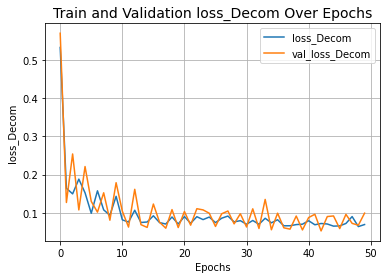

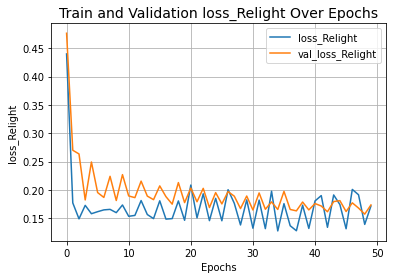

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss_Decom")
plot_result("loss_Relight")

## 預測 (inference)

In [ ]:
#畫出光線增強先後之影像
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

# 預測影像並輸出成能夠畫出的格式
def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = retinexNet_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

儲存與載入模型

In [ ]:
# https://blog.goodjack.tw/2020/04/create-datetime-with-timezone-via-python3-without-pytz.html
from datetime import datetime, timezone, timedelta
# 設定為 +8 時區
#tz = timezone(timedelta(hours=+8))
#now_time = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
#retinexNet_model.save_weights(f"./retinexnet_trained_model/{now_time}/retinexnet_weight_{100}epoch")

#decom_net = DecomNet()
#relight_net = RelightNet()
#my_retinexNet = RetinexNet(decom_net=decom_net, relight_net=relight_net)
#my_retinexNet.load_weights(f"./retinexnet__trained_model/{now_time}/retinexnet_weight_{100}epoch")

In [ ]:
# 測試
for i in range(len(test_low_light_images)):
  raw_image = Image.open(test_low_light_images[i])
  raw_image = keras.preprocessing.image.img_to_array(raw_image)
  raw_image = raw_image.astype("float32") / 255.0
  raw_image_ = np.expand_dims(raw_image, axis=0)

  enhanced_image = retinexNet_model(raw_image_)
  enhanced_image = tf.cast((enhanced_image[-1][0, :, :, :] * 255), dtype=np.uint8)
  enhanced_image = Image.fromarray(enhanced_image.numpy())

  real_image = Image.open(test_high_light_images[i])
  real_image = keras.preprocessing.image.img_to_array(real_image)
  real_image = real_image.astype("float32") / 255.0



  plot_results(
      [raw_image, real_image, enhanced_image],
      ["Raw", "Real", "Enhanced"],
      (20, 12),
  )